In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import string
from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from sklearn.feature_extraction.text import TfidfTransformer

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

import seaborn as sns

In [2]:
## import csvs ##
items = pd.read_csv('items.csv')

# Features Textuais

## Title entities

In [3]:
# Pipeline de língua inglesa pré-treinada 
# Componentes: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = en_core_web_sm.load()

In [4]:
def to_entities(text):
    '''
    Recebe um texto e devolve uma lista com as entidades (entities) desse texto
    
    '''
    doc = nlp(text)
    return[X.label_ for X in doc.ents]

In [5]:
def tuple_word_ent(txt):
    '''
    Recebe um texto e devolve uma lista de pares com (substantivo, entidade)
    
    '''
    doc = nlp(txt)
    return[(X.text,X.label_) for X in doc.ents]

In [6]:
# Retira as entidades de cada título para uma lista (Nova coluna: 'title_entities')
items['title_entities'] = items['new_title'].apply(lambda x: to_entities(x))

In [7]:
# Ocorrências de cada entidade nos títulos de notícias
title_ent = pd.Series(sum([item for item in items.title_entities], [])).value_counts()
title_ent

PERSON         10701
ORG             7255
GPE             6517
DATE            4542
CARDINAL        2943
NORP            2379
EVENT            720
ORDINAL          696
MONEY            663
LOC              495
WORK_OF_ART      424
FAC              313
TIME             296
PRODUCT          193
QUANTITY         118
PERCENT           90
LANGUAGE          44
LAW               41
dtype: int64

In [8]:
title_ent_rev = title_ent.sort_values(ascending=True)
title_ent_rev

LAW               41
LANGUAGE          44
PERCENT           90
QUANTITY         118
PRODUCT          193
TIME             296
FAC              313
WORK_OF_ART      424
LOC              495
MONEY            663
ORDINAL          696
EVENT            720
NORP            2379
CARDINAL        2943
DATE            4542
GPE             6517
ORG             7255
PERSON         10701
dtype: int64

In [9]:
frame = { 'entity_type': title_ent_rev.index, 'entity_count': title_ent_rev.values }
result = pd.DataFrame(frame)
result

,entity_type,entity_count
0,LAW,41
1,LANGUAGE,44
2,PERCENT,90
3,QUANTITY,118
4,PRODUCT,193
5,TIME,296
6,FAC,313
7,WORK_OF_ART,424
8,LOC,495
9,MONEY,663


Text(0, 0.5, 'Entidades')

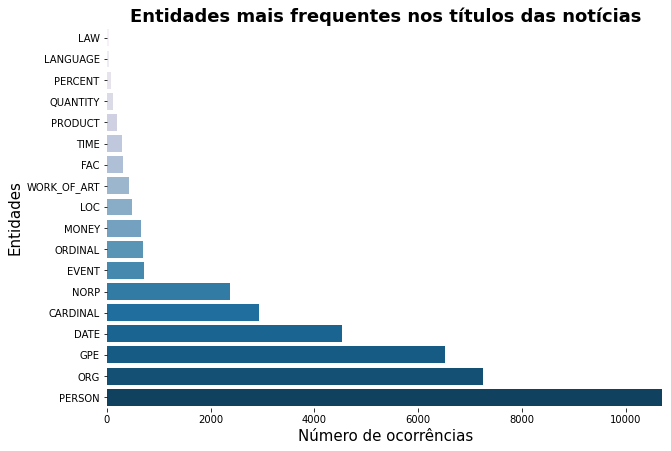

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="entity_count", y="entity_type", data=result, palette='PuBu')

# Add a legend and informative axis label
ax.set(xlim=(0, 10750), ylabel="", xlabel="Número de ocorrências")
sns.despine(left=True, bottom=True)

ax.set_title('Entidades mais frequentes nos títulos das notícias',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Número de ocorrências', fontsize = 15)
ax.set_ylabel('Entidades', fontsize = 15)

In [11]:
'''
OHE
'''

# 'title_entities' lists to String
strTtlEnt = items.title_entities.apply(', '.join)

# 'title_entities' OHE
oheTtlEnt = strTtlEnt.str.get_dummies(sep=', ').add_prefix('title_')

pd.set_option('display.max_columns', None)
items = pd.concat([items, oheTtlEnt], axis=1)
items.head(3)

,news_id,newsoutlet_id,news_tweet_date,news_url,new_title,news_date,news_text,title_entities,title_CARDINAL,title_DATE,title_EVENT,title_FAC,title_GPE,title_LANGUAGE,title_LAW,title_LOC,title_MONEY,title_NORP,title_ORDINAL,title_ORG,title_PERCENT,title_PERSON,title_PRODUCT,title_QUANTITY,title_TIME,title_WORK_OF_ART
0,1079995915652476928,28785486,2019-01-01 07:01:06,https://abcn.ws/2CIbHpE,China factory activity shrinks for the first t...,NaN,China's factory activity shrank in December fo...,"[GPE, ORDINAL, DATE]",0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1084275179331772416,28785486,2019-01-13 02:25:22,https://abcn.ws/2Fv3iri,Drone captures California man surfing with dol...,NaN,"Breathtaking drone video of a pod of friendly,...",[GPE],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1080216134467702784,28785486,2019-01-01 21:36:10,https://abcn.ws/2CHWRj9,"In 'unprecedented' speech, Kim Jong Un says No...",NaN,Kim Jong Un says he is ready to sit down again...,"[PERSON, GPE, GPE]",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


## Análise das entidades dos títulos das notícias

In [12]:
# Coluna com listas de tuplos (palavra(s),entidade)
items['tuple_title_entities'] = items['new_title'].apply(lambda x: tuple_word_ent(x))
items.head(3)

,news_id,newsoutlet_id,news_tweet_date,news_url,new_title,news_date,news_text,title_entities,title_CARDINAL,title_DATE,title_EVENT,title_FAC,title_GPE,title_LANGUAGE,title_LAW,title_LOC,title_MONEY,title_NORP,title_ORDINAL,title_ORG,title_PERCENT,title_PERSON,title_PRODUCT,title_QUANTITY,title_TIME,title_WORK_OF_ART,tuple_title_entities
0,1079995915652476928,28785486,2019-01-01 07:01:06,https://abcn.ws/2CIbHpE,China factory activity shrinks for the first t...,NaN,China's factory activity shrank in December fo...,"[GPE, ORDINAL, DATE]",0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,"[(China, GPE), (first, ORDINAL), (2 years, DATE)]"
1,1084275179331772416,28785486,2019-01-13 02:25:22,https://abcn.ws/2Fv3iri,Drone captures California man surfing with dol...,NaN,"Breathtaking drone video of a pod of friendly,...",[GPE],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[(California, GPE)]"
2,1080216134467702784,28785486,2019-01-01 21:36:10,https://abcn.ws/2CHWRj9,"In 'unprecedented' speech, Kim Jong Un says No...",NaN,Kim Jong Un says he is ready to sit down again...,"[PERSON, GPE, GPE]",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,"[(Kim Jong Un, PERSON), (North Korea, GPE), (U..."


In [13]:
# TITLE

# Lista entidades por tipo (de entidade).
# Apenas tivemos em conta as 4 primeiras ignorando os tipos
# DATE e CARDINAL que pela sua definição não se mostram relevantes.

personL, orgL, gpeL, norpL = ([] for i in range(4))

for lst in items.tuple_title_entities:
    for word,ent in lst:
        if ent=='PERSON':
            personL.append(word)
        if ent=='ORG':
            orgL.append(word)
        if ent=='GPE':
            gpeL.append(word)
        if ent=='NORP':
            norpL.append(word)

In [14]:
# top10 frequência de entidades do tipo PERSON
topPers=pd.Series(personL).value_counts().head(10).sort_values(ascending=True)
topPers

Kevin Hart           50
Jayme Closs          53
Kate Middleton       57
Katie Price          58
Elizabeth Warren     69
Andy Murray          70
Meghan Markle       132
Donald Trump        176
Trump               268
Brexit              711
dtype: int64

In [15]:
frame = { 'entity': topPers.index, 'entity_count': topPers.values }
dfP = pd.DataFrame(frame)
dfP

,entity,entity_count
0,Kevin Hart,50
1,Jayme Closs,53
2,Kate Middleton,57
3,Katie Price,58
4,Elizabeth Warren,69
5,Andy Murray,70
6,Meghan Markle,132
7,Donald Trump,176
8,Trump,268
9,Brexit,711


In [16]:
def grafico (data_,x_,y_,x_limit, titulo, x_label, y_label):
    f, ax = plt.subplots(figsize=(10, 7))

    sns.set_color_codes("pastel")
    sns.barplot(x=x_, y=y_, data=data_, palette='PuBu')

    ax.set(xlim=(0, x_limit), ylabel="", xlabel="Número de ocorrências")
    sns.despine(left=True, bottom=True)

    ax.set_title(titulo,fontsize = 18, fontweight='bold' )
    ax.set_xlabel(x_label, fontsize = 15)
    ax.set_ylabel(y_label, fontsize = 15)

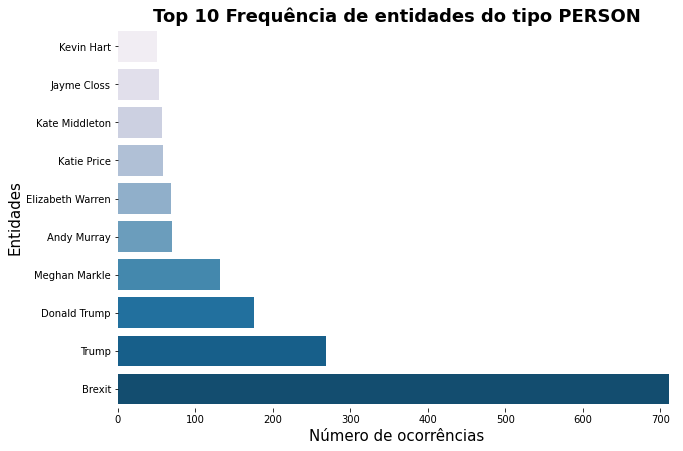

In [17]:
grafico(dfP,"entity_count","entity",
        720,
        "Top 10 Frequência de entidades do tipo PERSON",
        "Número de ocorrências","Entidades")

In [18]:
# top10 frequência de entidades do tipo ORG
topOrg = pd.Series(orgL).value_counts().head(10).sort_values(ascending=True)
topOrg

NFL             59
GOP             78
White House     90
Apple           94
BBC            103
Trump’s        104
Congress       112
EU             132
House          139
Trump          252
dtype: int64

In [19]:
frame = { 'entity': topOrg.index, 'entity_count': topOrg.values }
dfO = pd.DataFrame(frame)
dfO

,entity,entity_count
0,NFL,59
1,GOP,78
2,White House,90
3,Apple,94
4,BBC,103
5,Trump’s,104
6,Congress,112
7,EU,132
8,House,139
9,Trump,252


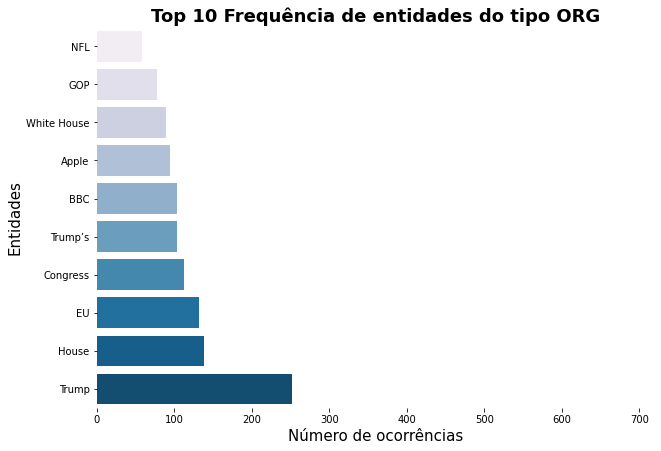

In [20]:
grafico(dfO,"entity_count","entity",
        720,
        "Top 10 Frequência de entidades do tipo ORG",
        "Número de ocorrências","Entidades")

In [21]:
# top10 frequência de entidades do tipo GPE
topGPE = pd.Series(gpeL).value_counts().head(10).sort_values(ascending=True)
topGPE

California    138
Syria         138
Russia        165
Theresa       168
London        209
U.S.          212
Britain       219
China         292
US            468
UK            483
dtype: int64

In [22]:
frame = { 'entity': topGPE.index, 'entity_count': topGPE.values }
dfG = pd.DataFrame(frame)
dfG

,entity,entity_count
0,California,138
1,Syria,138
2,Russia,165
3,Theresa,168
4,London,209
5,U.S.,212
6,Britain,219
7,China,292
8,US,468
9,UK,483


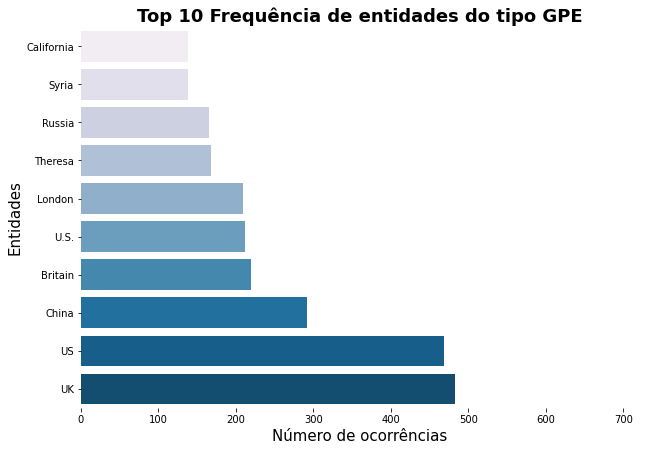

In [23]:
grafico(dfG,"entity_count","entity",
        720,
        "Top 10 Frequência de entidades do tipo GPE",
        "Número de ocorrências","Entidades")

In [24]:
# top10 frequência de entidades do tipo NORP
topNORP = pd.Series(norpL).value_counts().head(10).sort_values(ascending=True)
topNORP

Brits          55
German         56
Democratic     64
French         73
Chinese        77
American       91
Russian        98
Saudi         102
British       191
Democrats     262
dtype: int64

In [25]:
frame = { 'entity': topNORP.index, 'entity_count': topNORP.values }
dfN = pd.DataFrame(frame)
dfN

,entity,entity_count
0,Brits,55
1,German,56
2,Democratic,64
3,French,73
4,Chinese,77
5,American,91
6,Russian,98
7,Saudi,102
8,British,191
9,Democrats,262


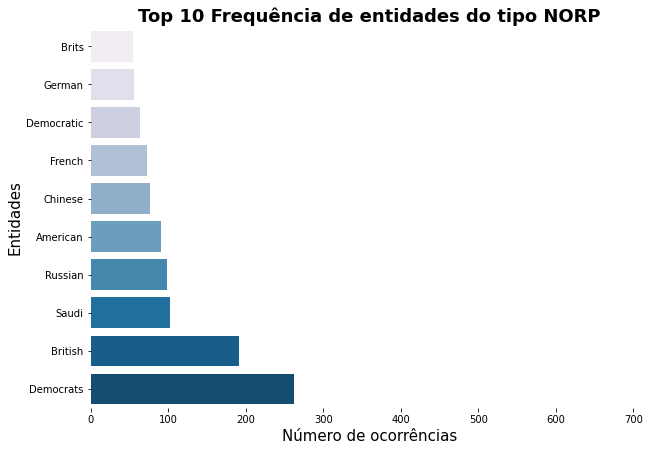

In [26]:
grafico(dfN,"entity_count","entity",
        720,
        "Top 10 Frequência de entidades do tipo NORP",
        "Número de ocorrências","Entidades")

## Title Entities Frequency
### v1 OHE com frequência das entidades

In [27]:
items_EFv1 = items[['news_id', 'tuple_title_entities']].copy()

In [28]:
# Cria colunas com o nome de cada tipo de entidade 
# e preenche com zeros todas as linhas
for ent_type in title_ent.index.tolist():
    items_EFv1['freq_' + ent_type] = 0
    
# preenche com a frequência de cada entidade
for index, row in items_EFv1.iterrows():
    for (word,ent) in row['tuple_title_entities']:
        items_EFv1['freq_' + ent].iloc[index] += 1


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
itemsEFv1 = items_EFv1.filter(regex=("news_id|^freq_")).copy()
itemsEFv1.head(3)

,news_id,freq_PERSON,freq_ORG,freq_GPE,freq_DATE,freq_CARDINAL,freq_NORP,freq_EVENT,freq_ORDINAL,freq_MONEY,freq_LOC,freq_WORK_OF_ART,freq_FAC,freq_TIME,freq_PRODUCT,freq_QUANTITY,freq_PERCENT,freq_LANGUAGE,freq_LAW
0,1079995915652476928,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1084275179331772416,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1080216134467702784,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# export do csv

itemsEFv1.to_csv('items_title_EFv1.csv', index=False)

### v2 OHE da frequência dos substantivos mais usados (a funcionar mas não adicionada ao items)

In [31]:
person = pd.Series(personL).value_counts()
org = pd.Series(orgL).value_counts()
gpe = pd.Series(gpeL).value_counts()
norp = pd.Series(norpL).value_counts()

top_nouns = pd.concat([person,org,gpe,norp]).sort_values(ascending=False)
top_nouns

Brexit                        711
UK                            483
US                            468
China                         292
Trump                         268
                             ... 
Jason Gardiner Backs Calls      1
Helen Mirren’                   1
Fatima Ali                      1
Laura Norton                    1
NKorean                         1
Length: 8520, dtype: int64

In [32]:
len(top_nouns)

8520

In [33]:
top200_nouns = top_nouns[:200]
top200_nouns

Brexit                711
UK                    483
US                    468
China                 292
Trump                 268
                     ... 
Michael Schumacher     17
Kentucky               17
Georgia                17
Venezuela              17
TSA                    16
Length: 200, dtype: int64

In [34]:
#Exporta a lista top200_nouns

import pickle

with open('top200_nouns.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(top200_nouns.index.tolist(), filehandle)

In [35]:
items_EFv2 = items[['news_id', 'tuple_title_entities']].copy()

In [36]:
# Cria colunas com o nome de cada tipo de entidade 
# e preenche com zeros todas as linhas
for ent_type in top200_nouns.index.tolist():
    items_EFv2['noun_freq_' + ent_type] = 0
    
# preenche com a frequência de cada entidade
for index, row in items_EFv2.iterrows():
    for (word,ent) in row['tuple_title_entities']:
        if word in top200_nouns:
            items_EFv2['noun_freq_' + word].iloc[index] += 1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [37]:
itemsEFv2 = items_EFv2.filter(regex=("news_id|noun_freq_")).copy()
itemsEFv2.head(3)

,news_id,noun_freq_Brexit,noun_freq_UK,noun_freq_US,noun_freq_China,noun_freq_Trump,noun_freq_Democrats,noun_freq_Britain,noun_freq_U.S.,noun_freq_London,noun_freq_British,noun_freq_Donald Trump,noun_freq_Theresa,noun_freq_Russia,noun_freq_House,noun_freq_California,noun_freq_Syria,noun_freq_Meghan Markle,noun_freq_EU,noun_freq_Congress,noun_freq_Trump’s,noun_freq_BBC,noun_freq_Saudi,noun_freq_Russian,noun_freq_Apple,noun_freq_Florida,noun_freq_American,noun_freq_White House,noun_freq_GOP,noun_freq_Chinese,noun_freq_Texas,noun_freq_French,noun_freq_Mexico,noun_freq_Australia,noun_freq_Washington,noun_freq_Andy Murray,noun_freq_Elizabeth Warren,noun_freq_India,noun_freq_Democratic,noun_freq_Paris,noun_freq_Germany,noun_freq_NFL,noun_freq_Katie Price,noun_freq_Amazon,noun_freq_Kate Middleton,noun_freq_New York,noun_freq_German,noun_freq_America,noun_freq_Brits,noun_freq_Jayme Closs,noun_freq_Brazil,noun_freq_Channel,noun_freq_Nazi,noun_freq_Iran,noun_freq_Kevin Hart,noun_freq_France,noun_freq_Poland,noun_freq_Thailand,noun_freq_Alexandria Ocasio-Cortez,noun_freq_Americans,noun_freq_NASA,noun_freq_Cheryl,noun_freq_ITV,noun_freq_Paul Whelan,noun_freq_Javid,noun_freq_Japan,noun_freq_Canada,noun_freq_England,noun_freq_Iceland,noun_freq_Australian,noun_freq_Kevin Spacey,noun_freq_Tesco,noun_freq_Republicans,noun_freq_Iraq,noun_freq_Alabama,noun_freq_Kate,noun_freq_FBI,noun_freq_Jeremy Corbyn,noun_freq_Anna Soubry,noun_freq_Italy,noun_freq_Gatwick,noun_freq_Surrey,noun_freq_Muslim,noun_freq_Harry,noun_freq_Republican,noun_freq_Moscow,noun_freq_Turkey,noun_freq_Liverpool,noun_freq_ISIS,noun_freq_Senate,noun_freq_Gemma Collins,noun_freq_Democrat,noun_freq_Mitt Romney,noun_freq_Las Vegas,noun_freq_Arizona,noun_freq_North Carolina,noun_freq_Whitfield,noun_freq_Nancy Pelosi,noun_freq_Premier League,noun_freq_Supreme Court,noun_freq_Black Mirror,noun_freq_Netflix,noun_freq_Rashida Tlaib,noun_freq_Putin,noun_freq_Egypt,noun_freq_CNN,noun_freq_Jeff Bezos,noun_freq_Guardian,noun_freq_Sydney,noun_freq_Bohemian,noun_freq_Manchester City,noun_freq_Irish,noun_freq_Saudi Arabia,noun_freq_Tottenham,noun_freq_Kim Jong Un,noun_freq_Meghan,noun_freq_Kim Kardashian,noun_freq_Chicago,noun_freq_North Korea,noun_freq_Chelsea,noun_freq_Universal Credit,noun_freq_Jeremy Hunt,noun_freq_D.C.,noun_freq_Puerto Rico,noun_freq_Indian,noun_freq_Sears,noun_freq_Pentagon,noun_freq_New York City,noun_freq_Hollywood,noun_freq_Donald Trump's,noun_freq_Boston,noun_freq_Wisconsin,noun_freq_Newcastle,noun_freq_Morocco,noun_freq_Iowa,noun_freq_Steve King,noun_freq_iPhone,noun_freq_North Korean,noun_freq_UN,noun_freq_Jazmine Barnes,noun_freq_Syrian,noun_freq_Japanese,noun_freq_Ireland,noun_freq_Cambridge,noun_freq_Tokyo,noun_freq_Piers Morgan,noun_freq_McDonald’s,noun_freq_Bird,noun_freq_Holly Willoughby,noun_freq_Khashoggi,noun_freq_Gordon Ramsay,noun_freq_Clemson,noun_freq_Indonesia,noun_freq_Mexican,noun_freq_Fed,noun_freq_Army,noun_freq_Parliament,noun_freq_Jair Bolsonaro,noun_freq_Beijing,noun_freq_South Africa,noun_freq_Pelosi,noun_freq_Israel,noun_freq_Spain,noun_freq_Cuba,noun_freq_Congo,noun_freq_Simon Cowell,noun_freq_Palestinian,noun_freq_Serena Williams,noun_freq_Meghan Markle’s,noun_freq_Billy Connolly,noun_freq_Dow,noun_freq_Barack Obama,noun_freq_R.,noun_freq_GoFundMe,noun_freq_NHS,noun_freq_European,noun_freq_Italian,noun_freq_Thai,noun_freq_Ruth Bader Ginsburg,noun_freq_Roger Federer,noun_freq_Idris Elba,noun_freq_Mass.,noun_freq_Houston,noun_freq_Philippines,noun_freq_New Horizons,noun_freq_WhatsApp,noun_freq_Corbyn,noun_freq_DC,noun_freq_Los Angeles,noun_freq_Michelle Obama,noun_freq_Luther,noun_freq_Jeremy Clarkson,noun_freq_Bob Einstein,noun_freq_Hillary Clinton,noun_freq_Michael Schumacher,noun_freq_Kentucky,noun_freq_Georgia,noun_freq_Venezuela,noun_freq_TSA
0,1079995915652476928,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [38]:
# export do csv

itemsEFv2.to_csv('items_title_EFv2.csv', index=False)

In [39]:
#items = pd.merge(items, items_EFv1, left_on='news_id', right_on='news_id', how='inner')
items = pd.merge(items, items_EFv2, left_on='news_id', right_on='news_id', how='inner')

## Text entities

In [40]:
# Retira as entidades de cada texto noticioso para uma lista (Nova coluna: 'text_entities')
items['text_entities'] = items['news_text'].apply(lambda x: to_entities(x))

In [41]:
# Ocorrências de cada entidade nos textos das notícias
text_ent = pd.Series(sum([item for item in items.text_entities], [])).value_counts()
text_ent

PERSON         368826
ORG            320365
DATE           290820
GPE            256846
CARDINAL       151401
NORP            91037
ORDINAL         39008
MONEY           32552
TIME            28222
WORK_OF_ART     24063
LOC             23694
FAC             20940
EVENT           14127
PRODUCT         12014
QUANTITY        10743
PERCENT          9716
LAW              3357
LANGUAGE         1423
dtype: int64

In [42]:
# 'text_entities' lists to String
strTextEnt = items.text_entities.apply(', '.join)

# 'text_entities' OHE
oheTextEnt = strTextEnt.str.get_dummies(sep=', ').add_prefix('text_')

pd.set_option('display.max_columns', None)
items = pd.concat([items, oheTextEnt], axis=1)
items.head(3)

,news_id,newsoutlet_id,news_tweet_date,news_url,new_title,news_date,news_text,title_entities,title_CARDINAL,title_DATE,title_EVENT,title_FAC,title_GPE,title_LANGUAGE,title_LAW,title_LOC,title_MONEY,title_NORP,title_ORDINAL,title_ORG,title_PERCENT,title_PERSON,title_PRODUCT,title_QUANTITY,title_TIME,title_WORK_OF_ART,tuple_title_entities_x,tuple_title_entities_y,noun_freq_Brexit,noun_freq_UK,noun_freq_US,noun_freq_China,noun_freq_Trump,noun_freq_Democrats,noun_freq_Britain,noun_freq_U.S.,noun_freq_London,noun_freq_British,noun_freq_Donald Trump,noun_freq_Theresa,noun_freq_Russia,noun_freq_House,noun_freq_California,noun_freq_Syria,noun_freq_Meghan Markle,noun_freq_EU,noun_freq_Congress,noun_freq_Trump’s,noun_freq_BBC,noun_freq_Saudi,noun_freq_Russian,noun_freq_Apple,noun_freq_Florida,noun_freq_American,noun_freq_White House,noun_freq_GOP,noun_freq_Chinese,noun_freq_Texas,noun_freq_French,noun_freq_Mexico,noun_freq_Australia,noun_freq_Washington,noun_freq_Andy Murray,noun_freq_Elizabeth Warren,noun_freq_India,noun_freq_Democratic,noun_freq_Paris,noun_freq_Germany,noun_freq_NFL,noun_freq_Katie Price,noun_freq_Amazon,noun_freq_Kate Middleton,noun_freq_New York,noun_freq_German,noun_freq_America,noun_freq_Brits,noun_freq_Jayme Closs,noun_freq_Brazil,noun_freq_Channel,noun_freq_Nazi,noun_freq_Iran,noun_freq_Kevin Hart,noun_freq_France,noun_freq_Poland,noun_freq_Thailand,noun_freq_Alexandria Ocasio-Cortez,noun_freq_Americans,noun_freq_NASA,noun_freq_Cheryl,noun_freq_ITV,noun_freq_Paul Whelan,noun_freq_Javid,noun_freq_Japan,noun_freq_Canada,noun_freq_England,noun_freq_Iceland,noun_freq_Australian,noun_freq_Kevin Spacey,noun_freq_Tesco,noun_freq_Republicans,noun_freq_Iraq,noun_freq_Alabama,noun_freq_Kate,noun_freq_FBI,noun_freq_Jeremy Corbyn,noun_freq_Anna Soubry,noun_freq_Italy,noun_freq_Gatwick,noun_freq_Surrey,noun_freq_Muslim,noun_freq_Harry,noun_freq_Republican,noun_freq_Moscow,noun_freq_Turkey,noun_freq_Liverpool,noun_freq_ISIS,noun_freq_Senate,noun_freq_Gemma Collins,noun_freq_Democrat,noun_freq_Mitt Romney,noun_freq_Las Vegas,noun_freq_Arizona,noun_freq_North Carolina,noun_freq_Whitfield,noun_freq_Nancy Pelosi,noun_freq_Premier League,noun_freq_Supreme Court,noun_freq_Black Mirror,noun_freq_Netflix,noun_freq_Rashida Tlaib,noun_freq_Putin,noun_freq_Egypt,noun_freq_CNN,noun_freq_Jeff Bezos,noun_freq_Guardian,noun_freq_Sydney,noun_freq_Bohemian,noun_freq_Manchester City,noun_freq_Irish,noun_freq_Saudi Arabia,noun_freq_Tottenham,noun_freq_Kim Jong Un,noun_freq_Meghan,noun_freq_Kim Kardashian,noun_freq_Chicago,noun_freq_North Korea,noun_freq_Chelsea,noun_freq_Universal Credit,noun_freq_Jeremy Hunt,noun_freq_D.C.,noun_freq_Puerto Rico,noun_freq_Indian,noun_freq_Sears,noun_freq_Pentagon,noun_freq_New York City,noun_freq_Hollywood,noun_freq_Donald Trump's,noun_freq_Boston,noun_freq_Wisconsin,noun_freq_Newcastle,noun_freq_Morocco,noun_freq_Iowa,noun_freq_Steve King,noun_freq_iPhone,noun_freq_North Korean,noun_freq_UN,noun_freq_Jazmine Barnes,noun_freq_Syrian,noun_freq_Japanese,noun_freq_Ireland,noun_freq_Cambridge,noun_freq_Tokyo,noun_freq_Piers Morgan,noun_freq_McDonald’s,noun_freq_Bird,noun_freq_Holly Willoughby,noun_freq_Khashoggi,noun_freq_Gordon Ramsay,noun_freq_Clemson,noun_freq_Indonesia,noun_freq_Mexican,noun_freq_Fed,noun_freq_Army,noun_freq_Parliament,noun_freq_Jair Bolsonaro,noun_freq_Beijing,noun_freq_South Africa,noun_freq_Pelosi,noun_freq_Israel,noun_freq_Spain,noun_freq_Cuba,noun_freq_Congo,noun_freq_Simon Cowell,noun_freq_Palestinian,noun_freq_Serena Williams,noun_freq_Meghan Markle’s,noun_freq_Billy Connolly,noun_freq_Dow,noun_freq_Barack Obama,noun_freq_R.,noun_freq_GoFundMe,noun_freq_NHS,noun_freq_European,noun_freq_Italian,noun_freq_Thai,noun_freq_Ruth Bader Ginsburg,noun_freq_Roger Federer,noun_freq_Idris Elba,noun_freq_Mass.,noun_freq_Houston,noun_freq_Philippines,noun_freq_New Horizons,noun_freq_WhatsApp,noun_freq_Corbyn,noun_freq_DC,noun_freq_Los Angeles,noun_freq_Michelle Obama,noun_freq_Luther,noun_freq_Jeremy 

## Title Keywords

RAKE-NLTK

In [43]:
from rake_nltk import Rake
# https://csurfer.github.io/rake-nltk/_build/html/index.html
# https://pypi.org/project/rake-nltk/

In [44]:
def get_keywords(text):
    # Uses stopwords for english from NLTK, and all puntuation characters.
    r = Rake(punctuations=string.punctuation+'’‘')
    # Extraction given the list of strings where each string is a sentence.
    r.extract_keywords_from_text(text)
    # To get keyword phrases ranked highest to lowest.
    return r.get_ranked_phrases()

In [45]:
# obtemos uma lista de keywords para cada título
items['ttl_keywords'] = items['new_title'].apply(lambda x: get_keywords(x))

In [46]:
string.punctuation+'’‘'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’‘'

In [47]:
# Contagem das keywords em todos os títulos
top_keywords = pd.Series(sum([item for item in items.ttl_keywords], [])).value_counts()
top_keywords.head(20)

trump                  525
year                   456
2019                   385
new year               385
2018                   343
brexit                 263
u                      234
death                  230
shutdown               192
world                  187
uk                     181
life                   177
woman                  163
government shutdown    161
man                    157
china                  151
ex                     147
know                   138
people                 134
day                    129
dtype: int64

In [48]:
kw_1plus = len([i for i in top_keywords.index if len(i)>1])
kws = len(top_keywords)
print(f'#keywords: {kws}; #keywords só com 1 caracter: {kws-kw_1plus}')

#keywords: 53396; #keywords só com 1 caracter: 32


In [49]:
'''
Apenas keywords com mais que um caracter e redefinimos a punctuation do rake
porque mesmo com a pipeline a remover pontuação não retirou caracteres como:
    ’ 1106 (1º mais frequente)
    ‘ 354 (5º mais frequente)
    u 234 (9º mais frequente)

E destas apenas vamos usar as 1000 mais frequentes
    
'''
# 1000 keywords relevantes mais frequentes
top1000_kw = [i for i in top_keywords.index if len(i)>1][:1000]

In [50]:
# Exporta a lista top1000_kw com as 1000 palavras-chave mais frequentes
with open('top1000_kw.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(top1000_kw, filehandle)

In [51]:
def filterKws(kw_list):
    return [i for i in kw_list if i in top1000_kw]

In [52]:
# A cada texto apenas extrai as keywords que pertencem às 1000 mais frequentes
def keywordsExt(text):
    r = Rake(punctuations=string.punctuation+'’‘')
    r.extract_keywords_from_text(text)
    kw_list = r.get_ranked_phrases()

    return filterKws(kw_list)

In [53]:
items['1000_ttl_keywords'] = items.new_title.apply(lambda x: keywordsExt(x))
items.head(3)

,news_id,newsoutlet_id,news_tweet_date,news_url,new_title,news_date,news_text,title_entities,title_CARDINAL,title_DATE,title_EVENT,title_FAC,title_GPE,title_LANGUAGE,title_LAW,title_LOC,title_MONEY,title_NORP,title_ORDINAL,title_ORG,title_PERCENT,title_PERSON,title_PRODUCT,title_QUANTITY,title_TIME,title_WORK_OF_ART,tuple_title_entities_x,tuple_title_entities_y,noun_freq_Brexit,noun_freq_UK,noun_freq_US,noun_freq_China,noun_freq_Trump,noun_freq_Democrats,noun_freq_Britain,noun_freq_U.S.,noun_freq_London,noun_freq_British,noun_freq_Donald Trump,noun_freq_Theresa,noun_freq_Russia,noun_freq_House,noun_freq_California,noun_freq_Syria,noun_freq_Meghan Markle,noun_freq_EU,noun_freq_Congress,noun_freq_Trump’s,noun_freq_BBC,noun_freq_Saudi,noun_freq_Russian,noun_freq_Apple,noun_freq_Florida,noun_freq_American,noun_freq_White House,noun_freq_GOP,noun_freq_Chinese,noun_freq_Texas,noun_freq_French,noun_freq_Mexico,noun_freq_Australia,noun_freq_Washington,noun_freq_Andy Murray,noun_freq_Elizabeth Warren,noun_freq_India,noun_freq_Democratic,noun_freq_Paris,noun_freq_Germany,noun_freq_NFL,noun_freq_Katie Price,noun_freq_Amazon,noun_freq_Kate Middleton,noun_freq_New York,noun_freq_German,noun_freq_America,noun_freq_Brits,noun_freq_Jayme Closs,noun_freq_Brazil,noun_freq_Channel,noun_freq_Nazi,noun_freq_Iran,noun_freq_Kevin Hart,noun_freq_France,noun_freq_Poland,noun_freq_Thailand,noun_freq_Alexandria Ocasio-Cortez,noun_freq_Americans,noun_freq_NASA,noun_freq_Cheryl,noun_freq_ITV,noun_freq_Paul Whelan,noun_freq_Javid,noun_freq_Japan,noun_freq_Canada,noun_freq_England,noun_freq_Iceland,noun_freq_Australian,noun_freq_Kevin Spacey,noun_freq_Tesco,noun_freq_Republicans,noun_freq_Iraq,noun_freq_Alabama,noun_freq_Kate,noun_freq_FBI,noun_freq_Jeremy Corbyn,noun_freq_Anna Soubry,noun_freq_Italy,noun_freq_Gatwick,noun_freq_Surrey,noun_freq_Muslim,noun_freq_Harry,noun_freq_Republican,noun_freq_Moscow,noun_freq_Turkey,noun_freq_Liverpool,noun_freq_ISIS,noun_freq_Senate,noun_freq_Gemma Collins,noun_freq_Democrat,noun_freq_Mitt Romney,noun_freq_Las Vegas,noun_freq_Arizona,noun_freq_North Carolina,noun_freq_Whitfield,noun_freq_Nancy Pelosi,noun_freq_Premier League,noun_freq_Supreme Court,noun_freq_Black Mirror,noun_freq_Netflix,noun_freq_Rashida Tlaib,noun_freq_Putin,noun_freq_Egypt,noun_freq_CNN,noun_freq_Jeff Bezos,noun_freq_Guardian,noun_freq_Sydney,noun_freq_Bohemian,noun_freq_Manchester City,noun_freq_Irish,noun_freq_Saudi Arabia,noun_freq_Tottenham,noun_freq_Kim Jong Un,noun_freq_Meghan,noun_freq_Kim Kardashian,noun_freq_Chicago,noun_freq_North Korea,noun_freq_Chelsea,noun_freq_Universal Credit,noun_freq_Jeremy Hunt,noun_freq_D.C.,noun_freq_Puerto Rico,noun_freq_Indian,noun_freq_Sears,noun_freq_Pentagon,noun_freq_New York City,noun_freq_Hollywood,noun_freq_Donald Trump's,noun_freq_Boston,noun_freq_Wisconsin,noun_freq_Newcastle,noun_freq_Morocco,noun_freq_Iowa,noun_freq_Steve King,noun_freq_iPhone,noun_freq_North Korean,noun_freq_UN,noun_freq_Jazmine Barnes,noun_freq_Syrian,noun_freq_Japanese,noun_freq_Ireland,noun_freq_Cambridge,noun_freq_Tokyo,noun_freq_Piers Morgan,noun_freq_McDonald’s,noun_freq_Bird,noun_freq_Holly Willoughby,noun_freq_Khashoggi,noun_freq_Gordon Ramsay,noun_freq_Clemson,noun_freq_Indonesia,noun_freq_Mexican,noun_freq_Fed,noun_freq_Army,noun_freq_Parliament,noun_freq_Jair Bolsonaro,noun_freq_Beijing,noun_freq_South Africa,noun_freq_Pelosi,noun_freq_Israel,noun_freq_Spain,noun_freq_Cuba,noun_freq_Congo,noun_freq_Simon Cowell,noun_freq_Palestinian,noun_freq_Serena Williams,noun_freq_Meghan Markle’s,noun_freq_Billy Connolly,noun_freq_Dow,noun_freq_Barack Obama,noun_freq_R.,noun_freq_GoFundMe,noun_freq_NHS,noun_freq_European,noun_freq_Italian,noun_freq_Thai,noun_freq_Ruth Bader Ginsburg,noun_freq_Roger Federer,noun_freq_Idris Elba,noun_freq_Mass.,noun_freq_Houston,noun_freq_Philippines,noun_freq_New Horizons,noun_freq_WhatsApp,noun_freq_Corbyn,noun_freq_DC,noun_freq_Los Angeles,noun_freq_Michelle Obama,noun_freq_Luther,noun_freq_Jeremy 

In [54]:
bow_transformer = CountVectorizer(analyzer=keywordsExt).fit(items['new_title'])

In [55]:
with open('bow_transformer.pkl', 'wb') as fout:
    pickle.dump(bow_transformer, fout)

In [56]:
len(bow_transformer.vocabulary_)

1000

In [57]:
bow_transformer.vocabulary_

{'first time': 338,
 'us': 934,
 'speech': 822,
 'ready': 719,
 'year': 993,
 'killer': 483,
 'hunt': 431,
 '000': 0,
 'shutdown': 797,
 'queen': 705,
 'husband': 432,
 'friend': 354,
 'need': 613,
 'know': 487,
 'everything': 298,
 'longest': 524,
 'abuse': 39,
 'father': 319,
 'pay': 661,
 'mexico': 569,
 'killing': 484,
 'hope': 422,
 'meet': 561,
 'family': 314,
 'years': 994,
 'list': 513,
 'president trump': 689,
 '2019': 15,
 'week': 969,
 'spain': 821,
 'sea': 773,
 'man accused': 545,
 'government': 383,
 'money': 584,
 'buy': 149,
 'road': 747,
 'hit': 415,
 'avoid': 84,
 'time address': 896,
 'southern border': 819,
 'prime': 691,
 'crisis': 218,
 'far side': 317,
 'moon': 588,
 'first': 336,
 'china': 182,
 'government shutdown': 384,
 'fact check': 309,
 'trump': 911,
 'says': 769,
 'longer': 523,
 'border wall': 123,
 'handling': 396,
 'new year': 618,
 'talks': 869,
 'best': 102,
 '2018': 14,
 'officials': 633,
 '22': 18,
 'truth': 917,
 'tell': 879,
 'watch': 965,
 'lin

In [58]:
title_bow = bow_transformer.transform(items['new_title'])
title_bow

<23932x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 29011 stored elements in Compressed Sparse Row format>

In [59]:
print('Shape of Sparse Matrix: ', title_bow.shape)
print('Amount of Non-Zero occurences: ', title_bow.nnz)

Shape of Sparse Matrix:  (23932, 1000)
Amount of Non-Zero occurences:  29011


In [60]:
ttl_kw_bow = pd.DataFrame.sparse.from_spmatrix(title_bow)
ttl_kw_bow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [61]:
items = pd.merge(items, ttl_kw_bow, left_index=True, right_index=True)

In [62]:
# export do csv

items.to_csv('items_news_content.csv', index=False)

## News_Text

In [63]:
def text_process(mess):
    # Retira pontuações
    nopunc = [char for char in mess if char not in string.punctuation]

    # Junta-os para formar strings
    nopunc = ''.join(nopunc)
    
    # Remove as stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [64]:
bow_transformer2 = CountVectorizer(analyzer=text_process).fit(items['news_text'])

In [65]:
messages_bow2 = bow_transformer2.transform(items['news_text'])

In [66]:
print('Shape of Sparse Matrix: ', messages_bow2.shape)
print('Amount of Non-Zero occurences: ', messages_bow2.nnz)

Shape of Sparse Matrix:  (23932, 238513)
Amount of Non-Zero occurences:  6395602


In [67]:
sparsity = (100.0 * messages_bow2.nnz / (messages_bow2.shape[0] * messages_bow2.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [68]:
tfidf_transformer = TfidfTransformer().fit(messages_bow2)
messages_tfidf = tfidf_transformer.transform(messages_bow2)
print(messages_tfidf.shape)

(23932, 238513)


## Serialize and Deserialize

In [69]:
scipy.sparse.save_npz('title_bow.npz', title_bow)

In [70]:
scipy.sparse.save_npz('messages_tfidf.npz', messages_tfidf)

In [71]:
title_bow = scipy.sparse.load_npz('title_bow.npz')
messages_tfidf = scipy.sparse.load_npz('messages_tfidf.npz')